# Scoring over 83%, is it really possible?  
Two years have passed since Chris Deotte pushed the top score of the Titanic competition at 82,8% (note that this score is evaluated with the new 100% public leaderboard, previously it was 85,1%, for more info check the discussion [here](https://www.kaggle.com/c/titanic/discussion/179147)).  
For sure he did a great job and inspired lots of people, but is there a way to improve on his work?  
This notebook finds some adult male survivors with a simple approach, so definitely yes... but can we score over 83%?  
If you are new to the competition, I recommend you to play for a while with it and come back later, otherwise let's get started!
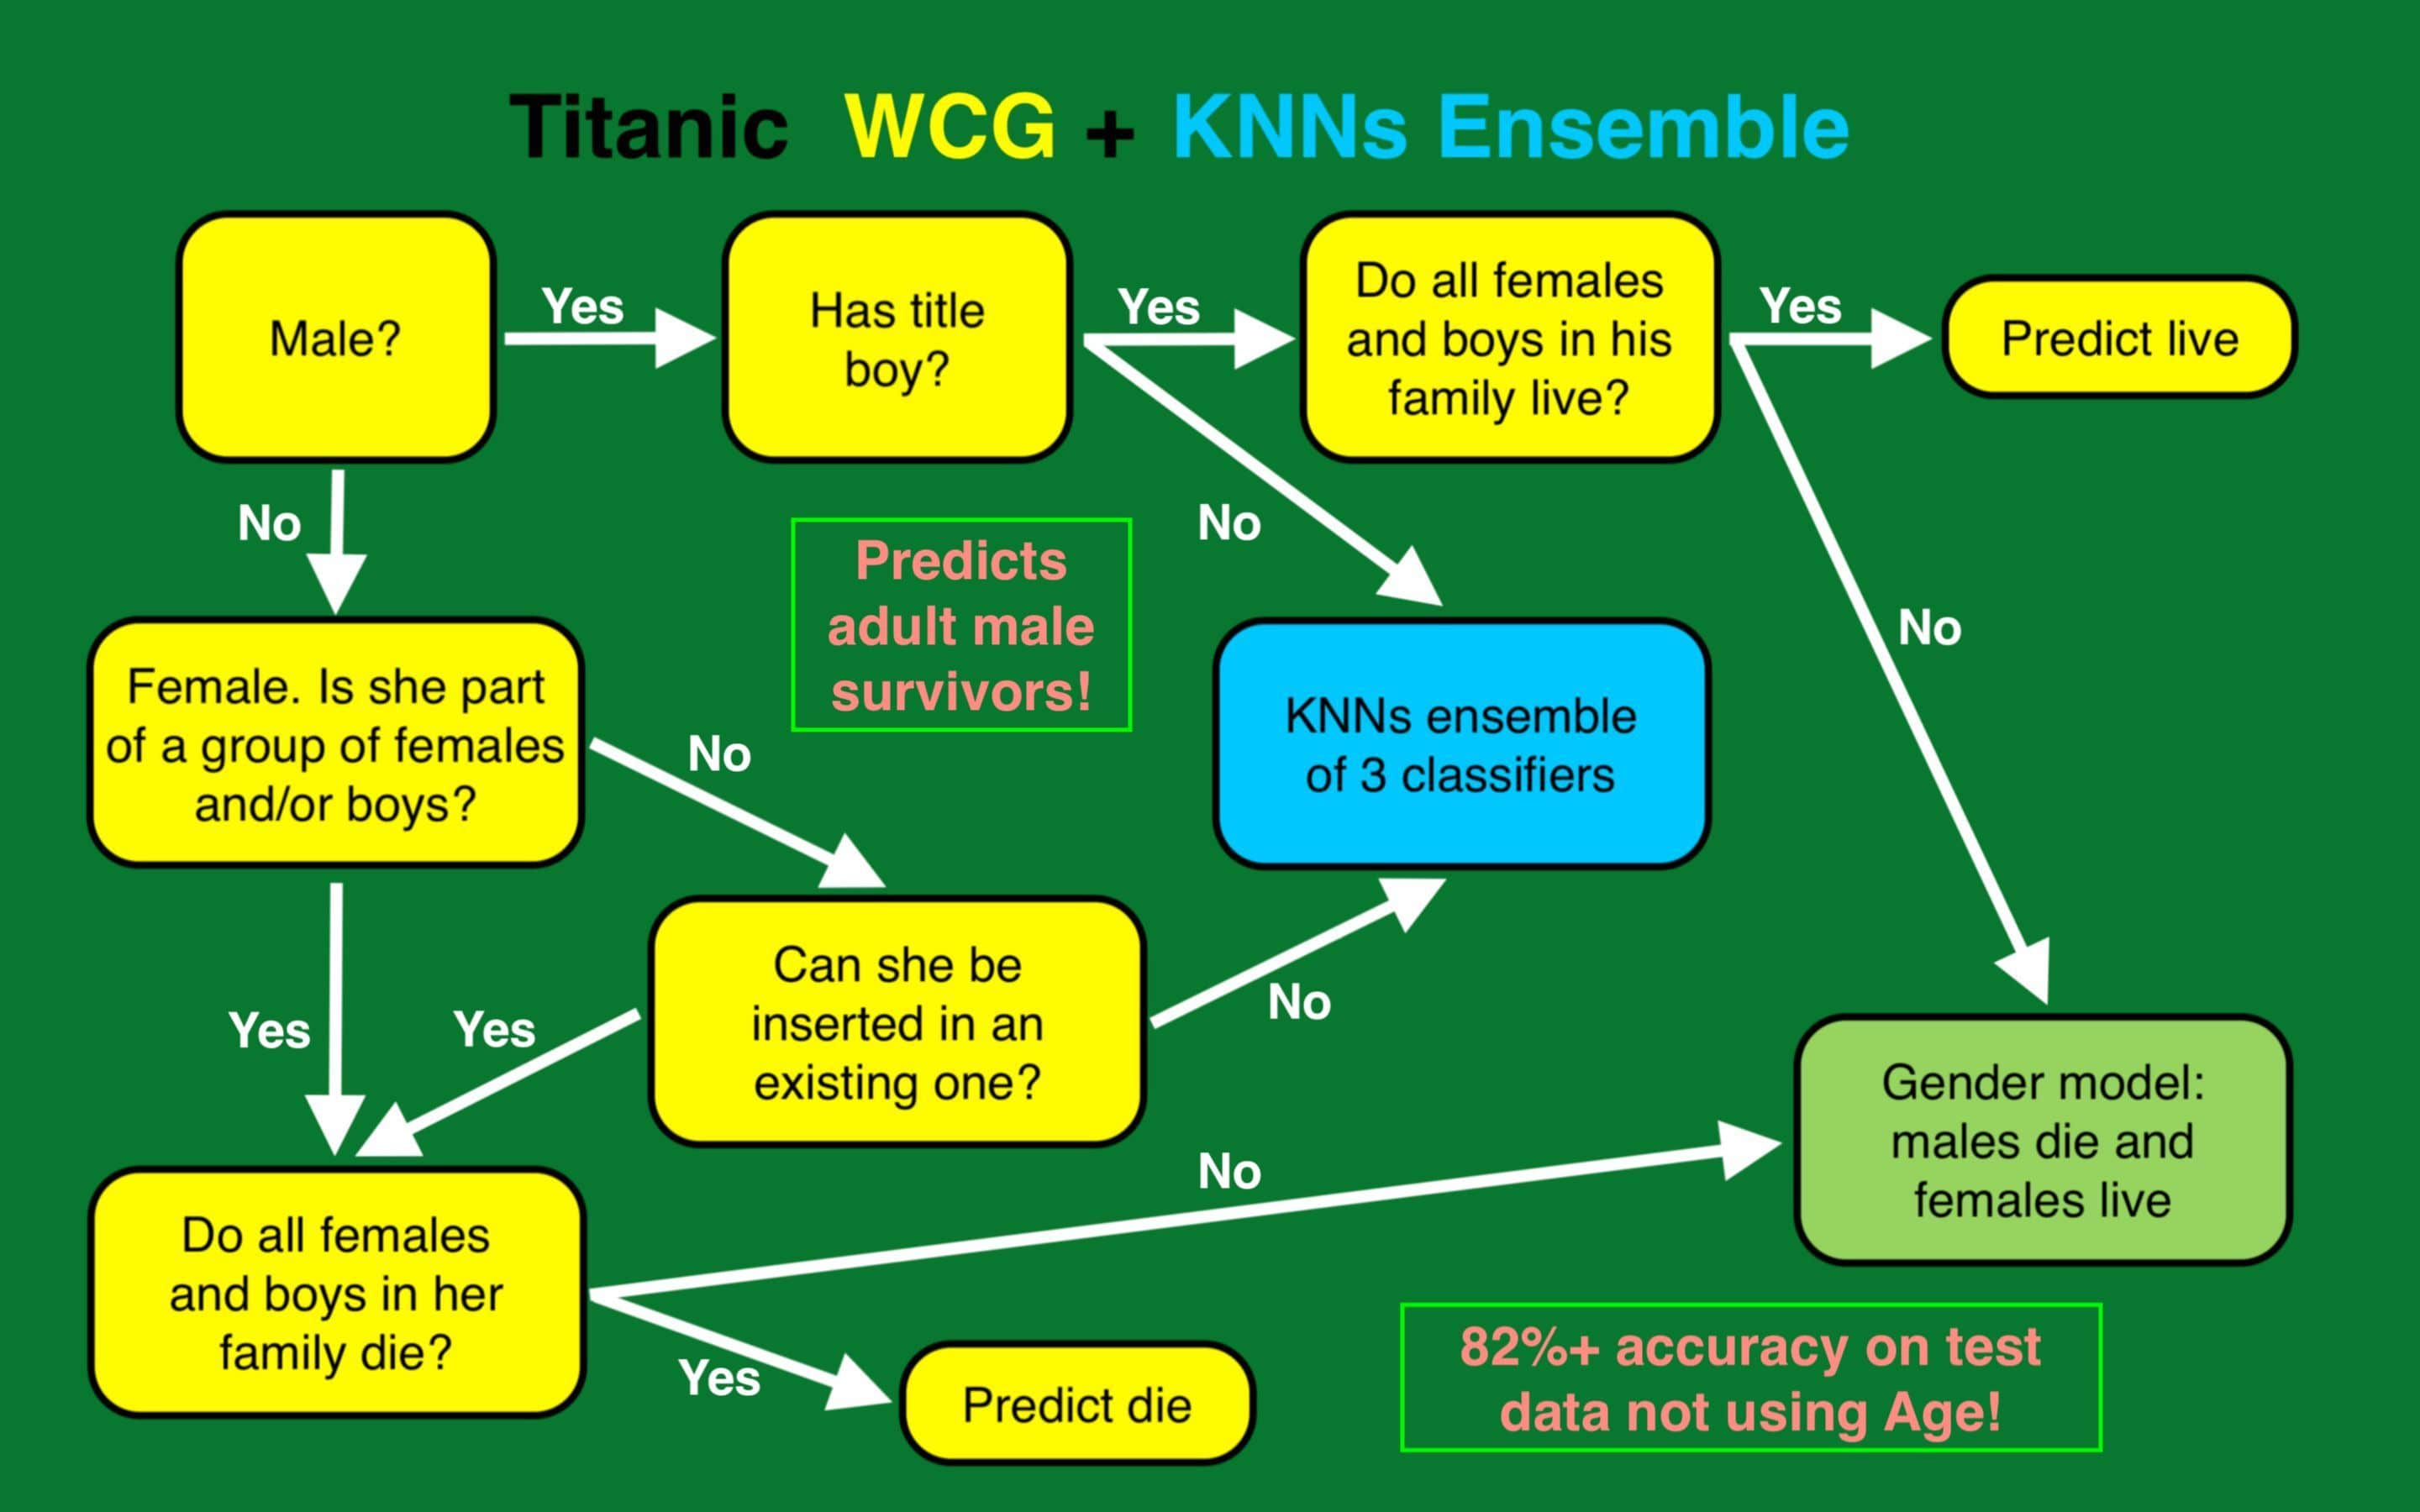

In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('dark')
sns.set_palette('Set2')
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier

We first load train and test data and join the two dataframes as it will be much easier to perform all our next operations.

In [ ]:
train_data = pd.read_csv('../input/titanic/train.csv')
test_data = pd.read_csv('../input/titanic/test.csv')
data = pd.concat([train_data, test_data]).reset_index().drop(['index'], axis=1)

# Woman-Child-Groups (WCG)
If we want to get the most accurate Titanic model ever, for sure we have to start with the best component available: let's code the final version of the WCG model developed by Chris in the first part of the [Titanic Mega Model](https://www.kaggle.com/cdeotte/titantic-mega-model-0-84210).  
If you haven't already, check that notebook out because it is really clear and contains one dotplot visualization that explains the idea behind the grouping models.  
Just with the WCG model, we will achieve 81,6% (confirmed to be 83,7% in the old public leaderboard before the change) and we will then work our way to the top.  
The first thing to do is extract the surname from the `Name` column, as it will be essential in engineering a `Group_id` feature that precisely identifies families.  

In [ ]:
data['Surname'] = data['Name'].apply(lambda x: x.split(',')[0])

For each passenger, let's now concatenate the strings `Surname + Pclass + Ticket + Fare + Embarked` to have an alphanumeric one under the name `Group_id`.  
As proved in [this](https://www.kaggle.com/erikbruin/titanic-2nd-degree-families-and-majority-voting) notebook by Erik Bruin, sometimes tickets of passengers traveling together differ in their last digit, so let's also remove the last digit to be consistent and identify the largest number of groups (for example, the `Ticket` value 'CA. 2343' will become 'CA. 234').  
The other features such as `SibSp` and `Parch` are purposely not included in the `Group_id` because they contain errors and are not equal for every family component.  
The `Cabin` column is not included either because too much data is missing.  
Let's write a group_id function that does exactly what we need.  
We pass through a `Ticket_id` helper column that we will reuse later.

In [ ]:
# New Ticket_id column
data['Ticket_id'] = 'new_col'
# Initialize Ticket_id = Pclass + Ticket + Fare + Embarked
def ticket_id(row):
    row['Ticket_id'] = str(row.Pclass) + '-' + str(row.Ticket)[:-1] + '-' + str(row.Fare) + '-' + str(row.Embarked)
    return row

data = data.apply(ticket_id, axis='columns')

In [ ]:
# New Group_id column
data['Group_id'] = 'new_col2'
# Initialize Group_id = Surname + Ticket_id
def group_id(row):
    row['Group_id'] = str(row.Surname) + '-' + str(row.Ticket_id)
    return row

data = data.apply(group_id, axis='columns')

Now we divide the passengers into three categories: men, women and children (only male ones).  
From the latter two, WCG will be created and we will assign a survival rate to the group so we can make predictions for each member in case he/she is in the test data.

In [ ]:
# creation of the Title feature
data['Title'] = 'man'
data.loc[data.Sex == 'female', 'Title'] = 'woman'
data.loc[data['Name'].str.contains('Master'), 'Title'] = 'boy'

We now assign the label 'noGroup' to every man and count the frequency for each `Group_id` element of the dataframe in the new `WC_count` column.  
We will then assign 'noGroup' also to every woman or child whose `Group_id` value is unique (i.e. with frequency one) in the entire dataframe.

In [ ]:
data.loc[data.Title == 'man', 'Group_id'] = 'noGroup'
# New column with WC frequency
data['WC_count'] = data.loc[data.Title != 'man'].groupby('Group_id')['Group_id'].transform('count')
# assign noGroup to every unique value
data.loc[data.WC_count <=1, 'Group_id'] = 'noGroup'

Now a great idea, which definitely helps: adding relatives to the groups we identified so far.  
What characteristics do these people share with the other group members?  
Well, they have a different `Surname` but all the other entries are equal, so they have the same `Ticket_id`.  
Let's see an example.

In [ ]:
cols = ['PassengerId', 'Survived', 'Name', 'Title', 'Ticket_id','Group_id']
data.loc[(data.Ticket_id == '1-1696-134.5-C') & (data.Title != 'man'), cols]

All these people have the same `Pclass`, `Fare`, `Embarked` and `Ticket` number, but two of them are considered part of any group: this is what we are going to fix.  
So let's search for these alone women (or children) which are most likely part of an already existing group.  
We loop through all the passengers whose `Group_id` is 'noGroup' and who are not adult males: if we find that their `Ticket_id` value occurs in an existing group, we change the passenger's `Group_id` entry.

In [ ]:
indices = []
count = 0
for i in range(0,1309):
    if (data.loc[i,'Title'] != 'man') & (data.loc[i,'Group_id'] == 'noGroup'):
        data.loc[i,'Group_id'] = data.loc[(data['Ticket_id'] == data.loc[i, 'Ticket_id']) & (data.Title != 'man'), 'Group_id'].iloc[0]
        if (data.loc[i, 'Group_id'] != 'noGroup'):
            indices.append(i)
            count += 1
print('{:d} passengers were added to an existing group'.format(count))

And here we are, 11 passengers were added to a group. Let's see them.

In [ ]:
cols = ['PassengerId', 'Survived', 'Name', 'Title', 'Group_id']
data.loc[indices, cols]

It looks like 9 of those 11 passengers are in the test data, so there is definitely the possibility to find other females who died, nice!  
Just to understand how many passengers are part of a group, let's make a quick analysis.

In [ ]:
number_of_groups = data.loc[data.Group_id != 'noGroup', 'Group_id'].nunique()
print('Number of groups found: {:d}'.format(number_of_groups))
number_of_WCG_passengers = data.loc[data.Group_id != 'noGroup', 'Group_id'].count()
print('\nNumber of passengers in a group: {:d}'.format(number_of_WCG_passengers))
composition = data.loc[data.Group_id != 'noGroup','Title'].value_counts()
print('\nComposition of the groups:')
print(composition.to_string())

So we found 80 woman-child-groups, for a total of 230 passengers: 171 women and 59 boys.  
Let's move on to the central aspect of this approach: calculate the average survival rate of each group.  
Here is how it is done: we simply group by `Group_id` and evaluate the mean for the known `Survived` values.

In [ ]:
data['WCSurvived'] = data.loc[(data.Title != 'man') & (data.Group_id != 'noGroup')].groupby('Group_id').Survived.transform('mean')

Now we have something like this: if a group has both passengers in the train and test data, the second ones have an associated `WCSurvived` value that is the mean of the `Survived` values in the train data for that particular group.

In [ ]:
cols = ['PassengerId', 'Survived', 'WCSurvived', 'Name', 'Title', 'Group_id']
data.loc[data.Group_id == 'Sage-3-CA. 234-69.55-S', cols]

We can understand the power of this approach now if we look at all the values that `WCSurvived` assumes.

In [ ]:
print('WCSurvived all data values:')
print(data.WCSurvived.value_counts().to_string())
plt.figure(figsize=(7,5))
f = sns.countplot(y=data.WCSurvived)

The unique values count confirms that generally the assumption that these groups lived or perished together is absolutely correct: that is the real power of the WCG model.  
Only 11 people have a non-integer `WCSurvived` value: the Allisons and the Asplunds.  
We see that most of them are in the train data, so for the only three people in the test set we will just use the gender model and hope for the best.  

In [ ]:
data.loc[(data.WCSurvived==0.75) | (data.WCSurvived==0.5), cols].sort_values(by='Group_id')

We are not done yet as there are some family groups with all members in the test data.  
For this reason, they have an unknown family survival rate, but we will assume that every component of the family underwent the same fate as our WCG hypothesis.

In [ ]:
# Get the family names using set difference
test_groups = set(data[891:1309].Group_id.unique()) - set(data[0:891].Group_id.unique())
data.loc[data.Group_id.isin(test_groups), cols].sort_values(by='Group_id')

These families are the Gibsons, Klasens, Peacocks, van Billiards.  
We need to make predictions for them so let's explore which woman-child-groups live or die.

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(12,6))
fig.suptitle('Woman-child-groups analysis', fontsize=14)
a = sns.barplot(x='Pclass', y='Survived', data=data[data.Group_id != 'noGroup'], ax=ax[0]).set_ylabel('Survival rate')
b = sns.barplot(x='Embarked', y='Survived', data=data[data.Group_id != 'noGroup'], ax=ax[1]).set_ylabel('Survival rate')

From this analysis, we immediately see that woman-child-groups traveling in `Pclass` 1 or 2 mostly survived and woman-child-groups in `Pclass` 3 mostly perished.  
Since the Gibsons had `Pclass` 1 and `Embarked` C while the Klasens, Peacocks, and van Billiards had `Pclass` 3 and `Embarked` S, our best bet is to assume that the Gibsons survived and the other three families died.

In [ ]:
# Assign WCSurvived = 0 to 3rd class test families, else 1
data.loc[data.Group_id.isin(test_groups), 'WCSurvived'] = 0
data.loc[(data.Group_id.isin(test_groups)) & (data.Pclass != 3), 'WCSurvived'] = 1

Now, this is the total number of passengers in the test set by `WCSurvived` value: we are finally ready to make predictions.

In [ ]:
print('WCSurvived test values:')
print(data[891:1309].WCSurvived.value_counts().to_string())

## Make WCG predictions and submission to Kaggle
There are 74 passengers part of a woman-child-group in the test dataset.  
Let's apply these two prediction rules on top of the gender model which simply predicts that all men (including children) die while all women live: 
* Predict die for all females whose entire family, excluding adult males, all die as indicated by the `WCSurvived` column equaling 0  
* Predict live for all boys whose entire family, excluding adult males, all live as indicated by the `WCSurvived` column equaling 1

In [ ]:
# Set everyone to 0
data.loc[891:1308, 'Predict'] = 0
# Set women to 1, completing the gender model
data.loc[891:1308, 'Predict'][(data.Sex == 'female')] = 1
# Change WCG women with WCSurvived=0 to 0
data.loc[891:1308,'Predict'][(data.Sex == 'female') & (data['WCSurvived'] == 0)] = 0
# Change WCG boys with WCSurvived=1 to 1, completing the WCG + gender model
data.loc[891:1308, 'Predict'][(data.Title == 'boy') & (data['WCSurvived'] == 1)] = 1
# With this, the three group members with non-integer WCSurvived are not changed from the gender model

Here is a summary of which passengers are predicted to live or die from the previous prediction rules.

In [ ]:
print('The following 8 males are predicted to live:')
cols = ['PassengerId', 'Name', 'Title', 'Group_id']
data[891:1309][cols].loc[(data.Title == 'boy') & (data.Predict == 1)]

In [ ]:
print('The following 15 females are predicted to die:')
data[891:1309][cols].loc[(data.Title == 'woman') & (data.Predict == 0)]

In [ ]:
print('The remaining 258 males are predicted to die')
print('and the remaining 137 females are predicted to live')

Now we submit the predictions to the leaderboard: at the time I first tried doing this, the old leaderboard with only 50% of test data was still in use.  
However, now that I am publishing the notebook, there is the new one that uses all of the test data to calculate the score and it appears that they are lower as much as 2% (reason explained [here](https://www.kaggle.com/c/titanic/discussion/179147)).

In [ ]:
output = pd.DataFrame({'PassengerId': data[891:1309].PassengerId, 'Survived': data[891:1309].Predict.astype('int')})
output.to_csv('WCG_gender.csv', index=False)
print('WCG_gender submission was successfully saved!')
print('Submission is loading... you scored 81,6%!')

Nice, as good as we expected!  
This extremely simple woman-child-group model scores 81,6% in the new and current leaderboard (341 correct predictions) which is really impressive.  
Considering that the gender submission scores 76,5% (which is 320 correct predictions) and this model changes 23 of them, it means 22/23 are correct!  
With the old leaderboard, I confirm that it was 83,7% so definitely not bad.
# Non-WCG passengers
For the second part of this notebook, we will focus on non-WCG passengers, who are adult males on one side and females who are not part of an existing group on the other.  
## Fixing the Fare column
Before starting we will do a couple of things.  
First of all, we fix rows with a `Fare` amount of 0 assigning them a null value that will be imputed later when we come to modeling.  
As pointed out by Erik Bruin [here](https://www.kaggle.com/erikbruin/titanic-2nd-degree-families-and-majority-voting), the information might be correct (a quick research showed for example that some of them were part of the guarantee group), but the zero-fares might confuse the algorithms as most of them are within the 1st and 2nd class passengers.  
In this notebook, I actually ended up using KNNs so this preprocessing makes no difference, but if I wanted to use something else this may help and that's why I leave it.

In [ ]:
# Assign np.NaN to zero-fares
def fix_fare(row):
    if row.Fare == 0:
        row.Fare = np.NaN
    return row
print('The following {:d} passengers have a zero Fare:'.format(data[data.Fare==0].shape[0]))
cols = ['PassengerId', 'Survived', 'Pclass','Fare', 'Name']
data.loc[data.Fare==0, cols]

Here you can see the difference before and after removing zero fares.  

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(12,8))
fig.suptitle('Removing zero fares: before and after', fontsize=14)
a = sns.swarmplot(x='Pclass', y='Fare', data=data, ax=ax[0])
ax[0].axhline(y=2, color='r')
# Apply the fix_fare function 
data = data.apply(fix_fare, axis='columns')
ax[1].axhline(y=2, color='r')
b = sns.swarmplot(x='Pclass', y='Fare', data=data, ax=ax[1])

Next, we modify the `Fare` column another time to create the `Pfare` feature that is just a passenger's `Fare` divided by his ticket frequency.  
This mostly helps in reducing the range of the `Fare` feature and also fixes some outliers.  
Again, here you find the difference before and after: note the scale difference on the y-axis.

In [ ]:
# Calculate Ticket frequency and divide Fare by it
data['Ticket_freq'] = data.groupby('Ticket')['Ticket'].transform('count')
data['Pfare'] = data['Fare'] / data['Ticket_freq']

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(12,8))
fig.suptitle('Fare and Pfare compared', fontsize=14)
a = sns.swarmplot(x='Pclass', y='Fare', data=data, ax=ax[0])
b = sns.swarmplot(x='Pclass', y='Pfare', data=data, ax=ax[1])

As you can see, the range is reduced from over 500 to 125, the second class is now more compact and the third class lost most of its outliers with really high fares.  
With these two small tweaks, we are now ready to go.
## Explore adult males
Adult males are the most difficult category to make predictions for.  
Most of the models we see here on Kaggle predict that all of them die and if not, usually the results are not satisfactory.  
Here my idea seems to work, even if not with magnificent results: let's dive into it.

In [ ]:
# Isolating adult males in train and test set
train_male = data[0:891].loc[(data.Sex=='male') & (data.WCSurvived.isnull())]
test_male = data[891:1309].loc[(data.Sex=='male') & (data.WCSurvived.isnull())]

Now let's perform a short analysis to see what features might be useful considering.  
In red I plotted the average survival rate for adult males in the train data.

In [ ]:
fig, ax = plt.subplots(2,2,figsize=(12,12))
fig.suptitle('Adult males EDA', fontsize=14)
sns.barplot(x='Pclass', y='Survived', data=train_male, ax=ax[0][0])
ax[0][0].axhline(y=train_male.Survived.mean(), color='r')
sns.barplot(x='Embarked', y='Survived', data=train_male, ax=ax[0][1])
ax[0][1].axhline(y=train_male.Survived.mean(), color='r')
sns.swarmplot(x='Pclass', y='Pfare', hue='Survived', data=train_male, ax=ax[1][0])
ax[1][0].axhline(y=25, color='y')
ax[1][0].axhline(y=32, color='y')
a = sns.swarmplot(y='Age', x='Pclass', hue='Survived', data=train_male, ax=ax[1][1])

We draw some interesting conclusions: `Pclass` is definitely useful and also `Embarked`, even though these two features are not independent (see why if you didn't know this).  
What about `Pfare`? We see there is a nice concentration of orange dots in the first class with `Pfare` between 25 and 32 (almost 50%), so this may be our best chance to guess some male survivors.  
What about `Age` instead? We recognize that the value of `Pclass` is the most discriminative because `Age` alone is very confusing (try tracing two horizontal lines as we did for `Pfare`).  
Let's see the distributions of the two numerical features to understand their influence on the target variable.

In [ ]:
x1 = train_male.loc[train_male['Survived']==1, 'Pfare']
x0 = train_male.loc[train_male['Survived']==0, 'Pfare']
y1 = train_male.loc[train_male['Survived']==1, 'Age']
y0 = train_male.loc[train_male['Survived']==0, 'Age']

fig, ax = plt.subplots(1,2,figsize=(12,6))
fig.suptitle('Age and Pfare distributions with hue Survived', fontsize=14)
sns.distplot(x1, bins=30, label = 'Survived', ax = ax[0], color = 'c')
sns.distplot(x0, bins=25, label = 'Not survived', ax = ax[0], color = 'y')
ax[0].set_xlim(-5, 70)
ax[0].legend()
sns.distplot(y1, bins=20, label = 'Survived', ax = ax[1], color = 'g')
sns.distplot(y0, bins=20, label = 'Not survived', ax = ax[1], color = 'r')
ax[1].legend()
fig.show()

We notice the `Age` distributions mostly overlap, while the `Pfare` ones do not (note the different height).  
So, is it leaving out `Age` the correct choice? I think yes.
## Let's build an ensemble
What information can we extract from the `Pfare`, `Pclass`, `Embarked` columns?  
Are they enough to detect some male survivors?  
Let's build an ensemble of three models and we will see!  
I used only K-Nearest Neighbors just to have fun: it may not be the best choice (and I am pretty sure about that) but I encourage you to fork this notebook and try your models.  
Since the classes are very imbalanced (the deads are more than 5 times the survivors), accuracy might not be a good metric here: for example, cross-validation accuracy for the predict all die model is 0.84!  
We are interested in precision and recall instead, i.e. respectively how many of the samples predicted as survivors actually lived and how many survivors are captured by our positive predictions.
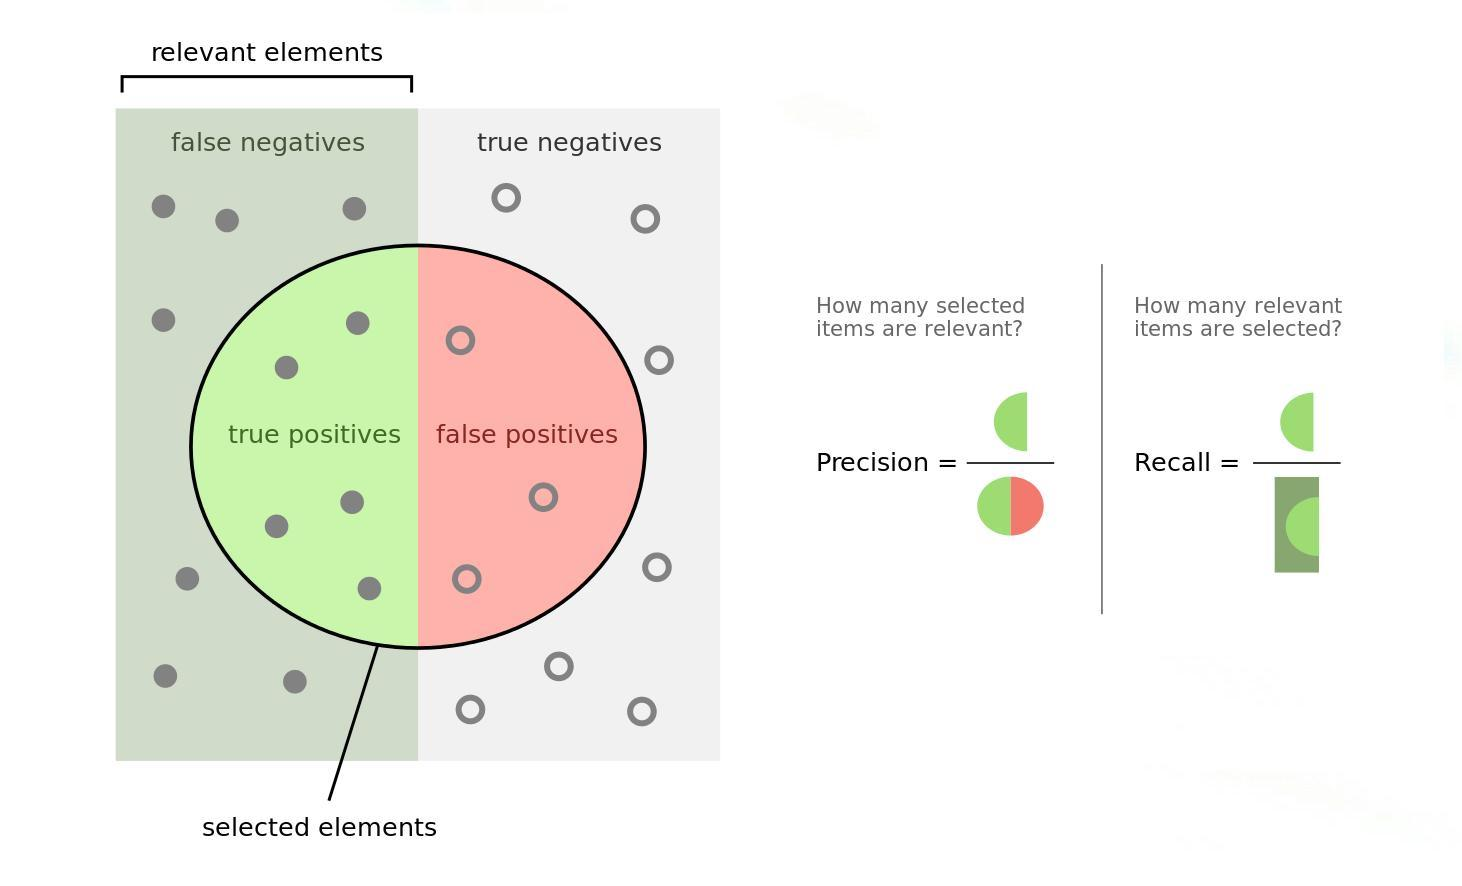
*Image by Walber - Own work, CC BY-SA 4.0, [link](https://commons.wikimedia.org/w/index.php?curid=36926283).*  

Since the survivors are very spread out, we don't expect our model to have a high recall but we would like to have a decent precision for sure.  
Note that with respect to these two metrics, the predict all die model has a score of 0.0 and 0.0!  
Let's see how these two metrics vary in a KNN model when we change the number of neighbors.

In [ ]:
cols = ['PassengerId', 'Name', 'Pfare', 'Pclass', 'Embarked']
y_m = train_male['Survived']
features = ['Pfare', 'Pclass', 'Embarked']
X_m = train_male[features]

numerical_cols = ['Pfare']
categorical_cols = ['Pclass', 'Embarked']

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer()),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_transformer, numerical_cols),
    ('cat', categorical_transformer, categorical_cols)
])

precision_m = []
recall_m = []

for k in range(1,18):
    pipeline1 = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', KNeighborsClassifier(n_neighbors=k))
    ])
    precision_m.append(cross_val_score(pipeline1, X_m, y_m, cv=15, n_jobs=-1, scoring='precision').mean())
    recall_m.append(cross_val_score(pipeline1, X_m, y_m, cv=15, n_jobs=-1, scoring='recall').mean())
    
k_range = range(1,18)
plt.figure(figsize=(7,5))
plt.plot(k_range, precision_m, label='15-fold precision')
plt.plot(k_range, recall_m, label='15-fold recall')
plt.axhline(y=0.5, color='r')
plt.xlabel('Value of k for KNN')
plt.title('Precision and recall by number of neighbors', fontsize=14)
plt.legend()
plt.show()

We see that an even or odd number of neighbors makes a significant difference in the recall score, while the precision has a nice trend almost independent from the parity.  
It is interesting to see that even when the recall is approximately zero, the models maintain a non-zero precision (even though they are pretty useless).  
Let's select our three values for k in the ensemble to be 1, 3 and 7.  
The reason is that the first two are supposed to detect most of the male survivors with a decent recall while the latter is a pretty good model on his own that will improve the total precision.  
I know this is a completely naive approach to an ensemble but forgive me for this!

In [ ]:
m1 = KNeighborsClassifier(n_neighbors=1)
m2 = KNeighborsClassifier(n_neighbors=3)
m3 = KNeighborsClassifier(n_neighbors=7)
# Preprocessing is the same as before
male_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('voting',VotingClassifier([
        ('m1', m1), ('m2', m2), ('m3', m3)]))
])
print('15-fold precision of the ensemble: {:.3f}'.format(
    cross_val_score(male_pipeline, X_m, y_m, cv=15, n_jobs=-1, scoring='precision').mean()))
print('15-fold recall of the ensemble: {:.3f}'.format(
    cross_val_score(male_pipeline, X_m, y_m, cv=15, n_jobs=-1, scoring='recall').mean()))
print('15-fold accuracy of the ensemble: {:.3f}'.format(
    cross_val_score(male_pipeline, X_m, y_m, cv=15, n_jobs=-1).mean()))
# Fit model and make predictions
male_pipeline.fit(X_m, y_m)
learn_train_m = male_pipeline.predict(X_m)
X_test_m = test_male[features]
predictions_m = male_pipeline.predict(X_test_m)
print('\nThe following 9 adult males are predicted to live:')
test_male.loc[(predictions_m==1), cols]

The 15-fold precision of the ensemble is 0.562, slightly better than 0.5 and in between the original precisions of the three models.  
I know finding some male survivors is a difficult task, so obtaining this >0.5 accuracy is a good result for me.  
Unfortunately, the 15-fold recall of the ensemble is only 0.318 but at least it did not go down from the original recalls of the three models.  
That is a consequence of the sparsity of the survivors, especially in the second and third classes where our model was not able to extract useful patterns (except one, Mr. Ling Hee in the third class!).  
Since we made 9 predictions, there is a concrete possibility that we find some male survivors this time!  
Just for fun, here I compare the train set, how the ensemble learns it and its predictions for the test data.

In [ ]:
fig, ax = plt.subplots(1,3,figsize=(15,8))
fig.suptitle('Fun comparison of train set vs test set', fontsize=14)
ax[0].set_title('Real train set')
ax[0].set_ylim(top=60)
sns.swarmplot(x=X_m.Pclass, y=X_m.Pfare, hue=y_m, ax=ax[0])
ax[1].set_title('Ensemble learns the train set')
ax[1].set_ylim(top=60)
sns.swarmplot(x=X_m.Pclass, y=X_m.Pfare, hue=learn_train_m,  ax=ax[1])
ax[2].set_title('Ensemble predicts the test set')
ax[2].set_ylim(top=60)
a = sns.swarmplot(x=test_male.Pclass, y=test_male.Pfare, hue=predictions_m,  ax=ax[2])

## Submission to Kaggle
Let's change the adult male predictions of the ensemble from the gender model and submit.  
An advantage of the new 100% public leaderboard is that we have now the possibility to count exactly how many correct predictions we make.

In [ ]:
data.loc[891:1308, 'Predict'][(data.Sex=='male') & (data.WCSurvived.isnull())] = predictions_m
output = pd.DataFrame({'PassengerId': data[891:1309].PassengerId, 'Survived': data[891:1309].Predict.astype('int')})
output.to_csv('WCG_male.csv', index=False)
print('WCG_male submission was successfully saved!')
print('Submission is loading... you scored 82,3%!')

Wow, we scored 82,3% which is 344 passengers, 3 more correct predictions than the WCG + gender model!  
It means 6 out of our 9 male predictions were correct: we finally found a way to guess some male survivors, yeah!
## Explore non-WCG females
Non-WCG females are a very wide group which contains solo females but also women traveling with their spouse.  
A way to isolate them from the dataframe is of course select null `WCSurvived` entries from the female subpopulation.

In [ ]:
train_female = data[0:891].loc[(data.Sex=='female')  & (data.WCSurvived.isnull())]
test_female = data[891:1309].loc[(data.Sex=='female') & (data.WCSurvived.isnull())]

As we did before, let's run a quick analysis to see if we can use more features or if `Age` is again not useful.

In [ ]:
fig, ax = plt.subplots(2,2,figsize=(12,12))
fig.suptitle('Non-WCG females EDA', fontsize=14)
sns.barplot(x='Pclass', y='Survived', data=train_female, ax=ax[0][0])
ax[0][0].axhline(y=train_female.Survived.mean(), color='r')
sns.barplot(x='Embarked', y='Survived', data=train_female, ax=ax[0][1])
ax[0][1].axhline(y=train_female.Survived.mean(), color='r')
sns.swarmplot(x='Pclass', y='Pfare', hue='Survived', data=train_female, ax=ax[1][0])
ax[1][0].set_ylim(top=70)
ax[1][0].axhline(y=7, color='y')
ax[1][0].axhline(y=10, color='y')
a = sns.swarmplot(y='Age', x='Pclass', hue='Survived', data=train_female, ax=ax[1][1])

For non-WCG females, we definitely see that `Pclass` will be determinant another time and that we have to focus on third-class because the survival rates elsewhere are really high.  
We see there is a decent concentration of green dots in the third class with `Pfare` between 7 and 10, so this may be our best chance to guess some females who died.  
Let's see `Age` and `Pfare` distributions to understand their importance.

In [ ]:
w1 = train_female.loc[train_female['Survived']==1, 'Pfare']
w0 = train_female.loc[train_female['Survived']==0, 'Pfare']
z1 = train_female.loc[train_female['Survived']==1, 'Age']
z0 = train_female.loc[train_female['Survived']==0, 'Age']

fig, ax = plt.subplots(1,2,figsize=(12,6))
fig.suptitle('Age and Pfare distributions with hue Survived', fontsize=14)
sns.distplot(w1, bins=35, label = 'Survived', ax = ax[0], color = 'c')
sns.distplot(w0, bins=15, label = 'Not survived', ax = ax[0], color = 'y')
ax[0].set_xlim(-5, 60)
ax[0].legend()
sns.distplot(z1, bins=12, label = 'Survived', ax = ax[1], color = 'g')
sns.distplot(z0, bins=10, label = 'Not survived', ax = ax[1], color = 'r')
ax[1].legend()
fig.show()

We notice `Age` is again not really astonishing while `Pfare` is the one which will help us the most.  
Let's try not to use `Age` and hope for the best: we already found some male survivors so we are more than happy with the result.
## Let's build an ensemble, again
We will make our predictions through an ensemble of three models, using KNNs just for fun.  
I encourage you to fork this notebook and try your models if you don't like this choice!  
Since the classes are very imbalanced another time (the survivors are 4.5 times the deads), accuracy is not a good metric here: for example, cross-validation accuracy for the predict all live model is 0.818!  
Since sklearn metrics use 1 as the default value for positive samples, we have to create our custom metrics that use 0 as the positive value.

In [ ]:
from sklearn.metrics import make_scorer, precision_score, recall_score
# We set zero_division=0 to avoid raising errors
custom_precision = make_scorer(precision_score, pos_label=0, zero_division=0)
custom_recall = make_scorer(recall_score, pos_label=0)

Again, we don't expect our model to have a high recall but we would like to have a decent precision.  
Note that with respect to these two custom metrics, the predict all live model has a score of 0.0 and 0.0!  
Let's vary the number of neighbors in a KNN model and see how these two quantities change.

In [ ]:
y_f = train_female['Survived']
X_f = train_female[features]
precision_f = []
recall_f = []
# Preprocessing is always the same...
for k in range(1,18):
    pipeline2 = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', KNeighborsClassifier(n_neighbors=k))
    ])
    # We use 9-fold because the train size is smaller
    # and 198/9 = integer
    precision_f.append(cross_val_score(pipeline2, X_f, y_f, cv=9, n_jobs=-1, scoring=custom_precision).mean())
    recall_f.append(cross_val_score(pipeline2, X_f, y_f, cv=9, n_jobs=-1, scoring=custom_recall).mean())
    
plt.figure(figsize=(7,5))
plt.plot(k_range, precision_f, label='9-fold precision')
plt.plot(k_range, recall_f, label='9-fold recall')
plt.axhline(y=0.5, color='r')
plt.xlabel('Value of k for KNN')
plt.title('Precision and recall by number of neighbors', fontsize=14)
plt.legend()
plt.show()

Oh, what a strange plot!  
We see the effect of parity is huge, that it takes a while to increase accuracy over 0.5 and that we have to lose almost half of the recall to gain that.  
This time, precision and recall also go to zero at the same time which is a cool thing.  
I'll try to select the KNN models with k values of 4, 9, 11 with a similar logic as before: we take the high recall of the first, we combine it to the high precision of the second and we add the third that has a little bit of both.  
Let's see how it goes...

In [ ]:
f1 = KNeighborsClassifier(n_neighbors=4)
f2 = KNeighborsClassifier(n_neighbors=9)
f3 = KNeighborsClassifier(n_neighbors=11)
# Preprocessing pipelines are the same as before
female_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('voting', VotingClassifier([
        ('f1', f1), ('f2', f2), ('f3', f3)]))
])
print('9-fold precision of the ensemble: {:.3f}'.format(
    cross_val_score(female_pipeline, X_f, y_f, cv=9, scoring=custom_precision).mean()))
print('9-fold recall of the ensemble: {:.3f}'.format(
    cross_val_score(female_pipeline, X_f, y_f, cv=9, scoring=custom_recall).mean()))
print('9-fold accuracy of the ensemble: {:.3f}'.format(
    cross_val_score(female_pipeline, X_f, y_f, cv=9).mean()))
# Preprocessing of training data, fit model
female_pipeline.fit(X_f, y_f)
learn_train_f = female_pipeline.predict(X_f)
X_test_f = test_female[features]
predictions_f = female_pipeline.predict(X_test_f)
print('\nThe following 6 non-WCG females are predicted to die:')
test_female.loc[(predictions_f==0), cols]

Wow, the 9-fold precision for the ensemble is 0.571, at least it did not go down!  
The recall isn't great but it's ok, also this one is a difficult task and we don't expect a lot more than this.      
I'm surprised that we made only 6 predictions, but it is what it is with such a small test set (only 97 rows).  
As I did before, here I compare the train set, how the ensemble learns it and its predictions for the test data.  
Thanks to this plot, we can also see that non-WCG females in the third class are not distributed as in the train data and this may explain why we made only a few predictions.  

In [ ]:
fig, ax = plt.subplots(1,3,figsize=(15,8))
fig.suptitle('Fun comparison of train set vs test set', fontsize=14)
ax[0].set_title('Real train set')
ax[0].set_ylim(top=55)
sns.swarmplot(x=X_f.Pclass, y=X_f.Pfare, hue=y_f, ax=ax[0])
ax[1].set_title('Ensemble learns the train set')
ax[1].set_ylim(top=55)
sns.swarmplot(x=X_f.Pclass, y=X_f.Pfare, hue=learn_train_f,  ax=ax[1])
ax[2].set_title('Ensemble predicts the test set')
ax[2].set_ylim(top=55)
a = sns.swarmplot(x=test_female.Pclass, y=test_female.Pfare, hue=predictions_f,  ax=ax[2])

It's actually pretty funny to see how the ensemble learns the train set but hey, if it works I keep it!
## Final Submission
Now it's time to see if we have a good model that predicts which females die.  
Hopefully, we have the same increment as before and have the best Titanic model ever!  
Let's change these female predictions from the previous model and submit to Kaggle.

In [ ]:
data.loc[891:1308, 'Predict'][(data.Sex=='female') & (data.WCSurvived.isnull())] = predictions_f
output = pd.DataFrame({'PassengerId': data[891:1309].PassengerId, 'Survived': data[891:1309].Predict.astype('int')})
output.to_csv('WCG_male_female.csv', index=False)
print('WCG_male_female was successfully saved!')
print('Submission is loading... you scored 82,8%!')

Wow! Our score increased again and it is now 82,8% which is 346 passengers, 2 more correct predictions than the WCG + adult males model!  
Unfortunately, this is exactly the top score previously available so we were not able to make a breakthrough over 83%... or did we?  
Well, we found some male survivors, that's a great win for me because this is something no one has ever succeeded doing and also indirectly is pushing the top score over its limit.      
If I had ensembled different models for non-WCG females (maybe including `Age` too), I could have probably scored over 83% but that's just an idea I leave here for the readers!  
# Conclusion
First of all, I would like to thank [Chris](https://www.kaggle.com/cdeotte) for his amazing Titanic tutorials as well as [Erik](https://www.kaggle.com/erikbruin) for his careful family analysis and `Fare` tricks which helped a bit.      
Secondly, thank you for reading my notebook!  
I hope you liked it: this was my attempt to push the top score higher and even if I did not succeed, it was still a nice journey.  
I had to look at the problem from another perspective and not using the `Age` column ended up being a way to find some male survivors, so at least I made an important contribution.  
This notebook proves another time that the two tasks of predicting adult male survivors and females not in a group who died are very different and it is really difficult to do both well with the same approach.  
I believe it is possible to increase the public score again ensembling this model with others, mostly to correct some of the female predictions: I think the maximum score achievable could be around 350 passengers, which is 83,7%.  
That being said, I finish this notebook with a short summary of what we did.
# Summary of what we did
This notebook proved that male survivors can be found with simple elements and thus the old top scores have the potential to be improved, especially if we use the WCG model as a strong baseline.  
Here's the pipeline we followed to reach top 1% in the competition and an histogram of Titanic LB scores in September 2020.
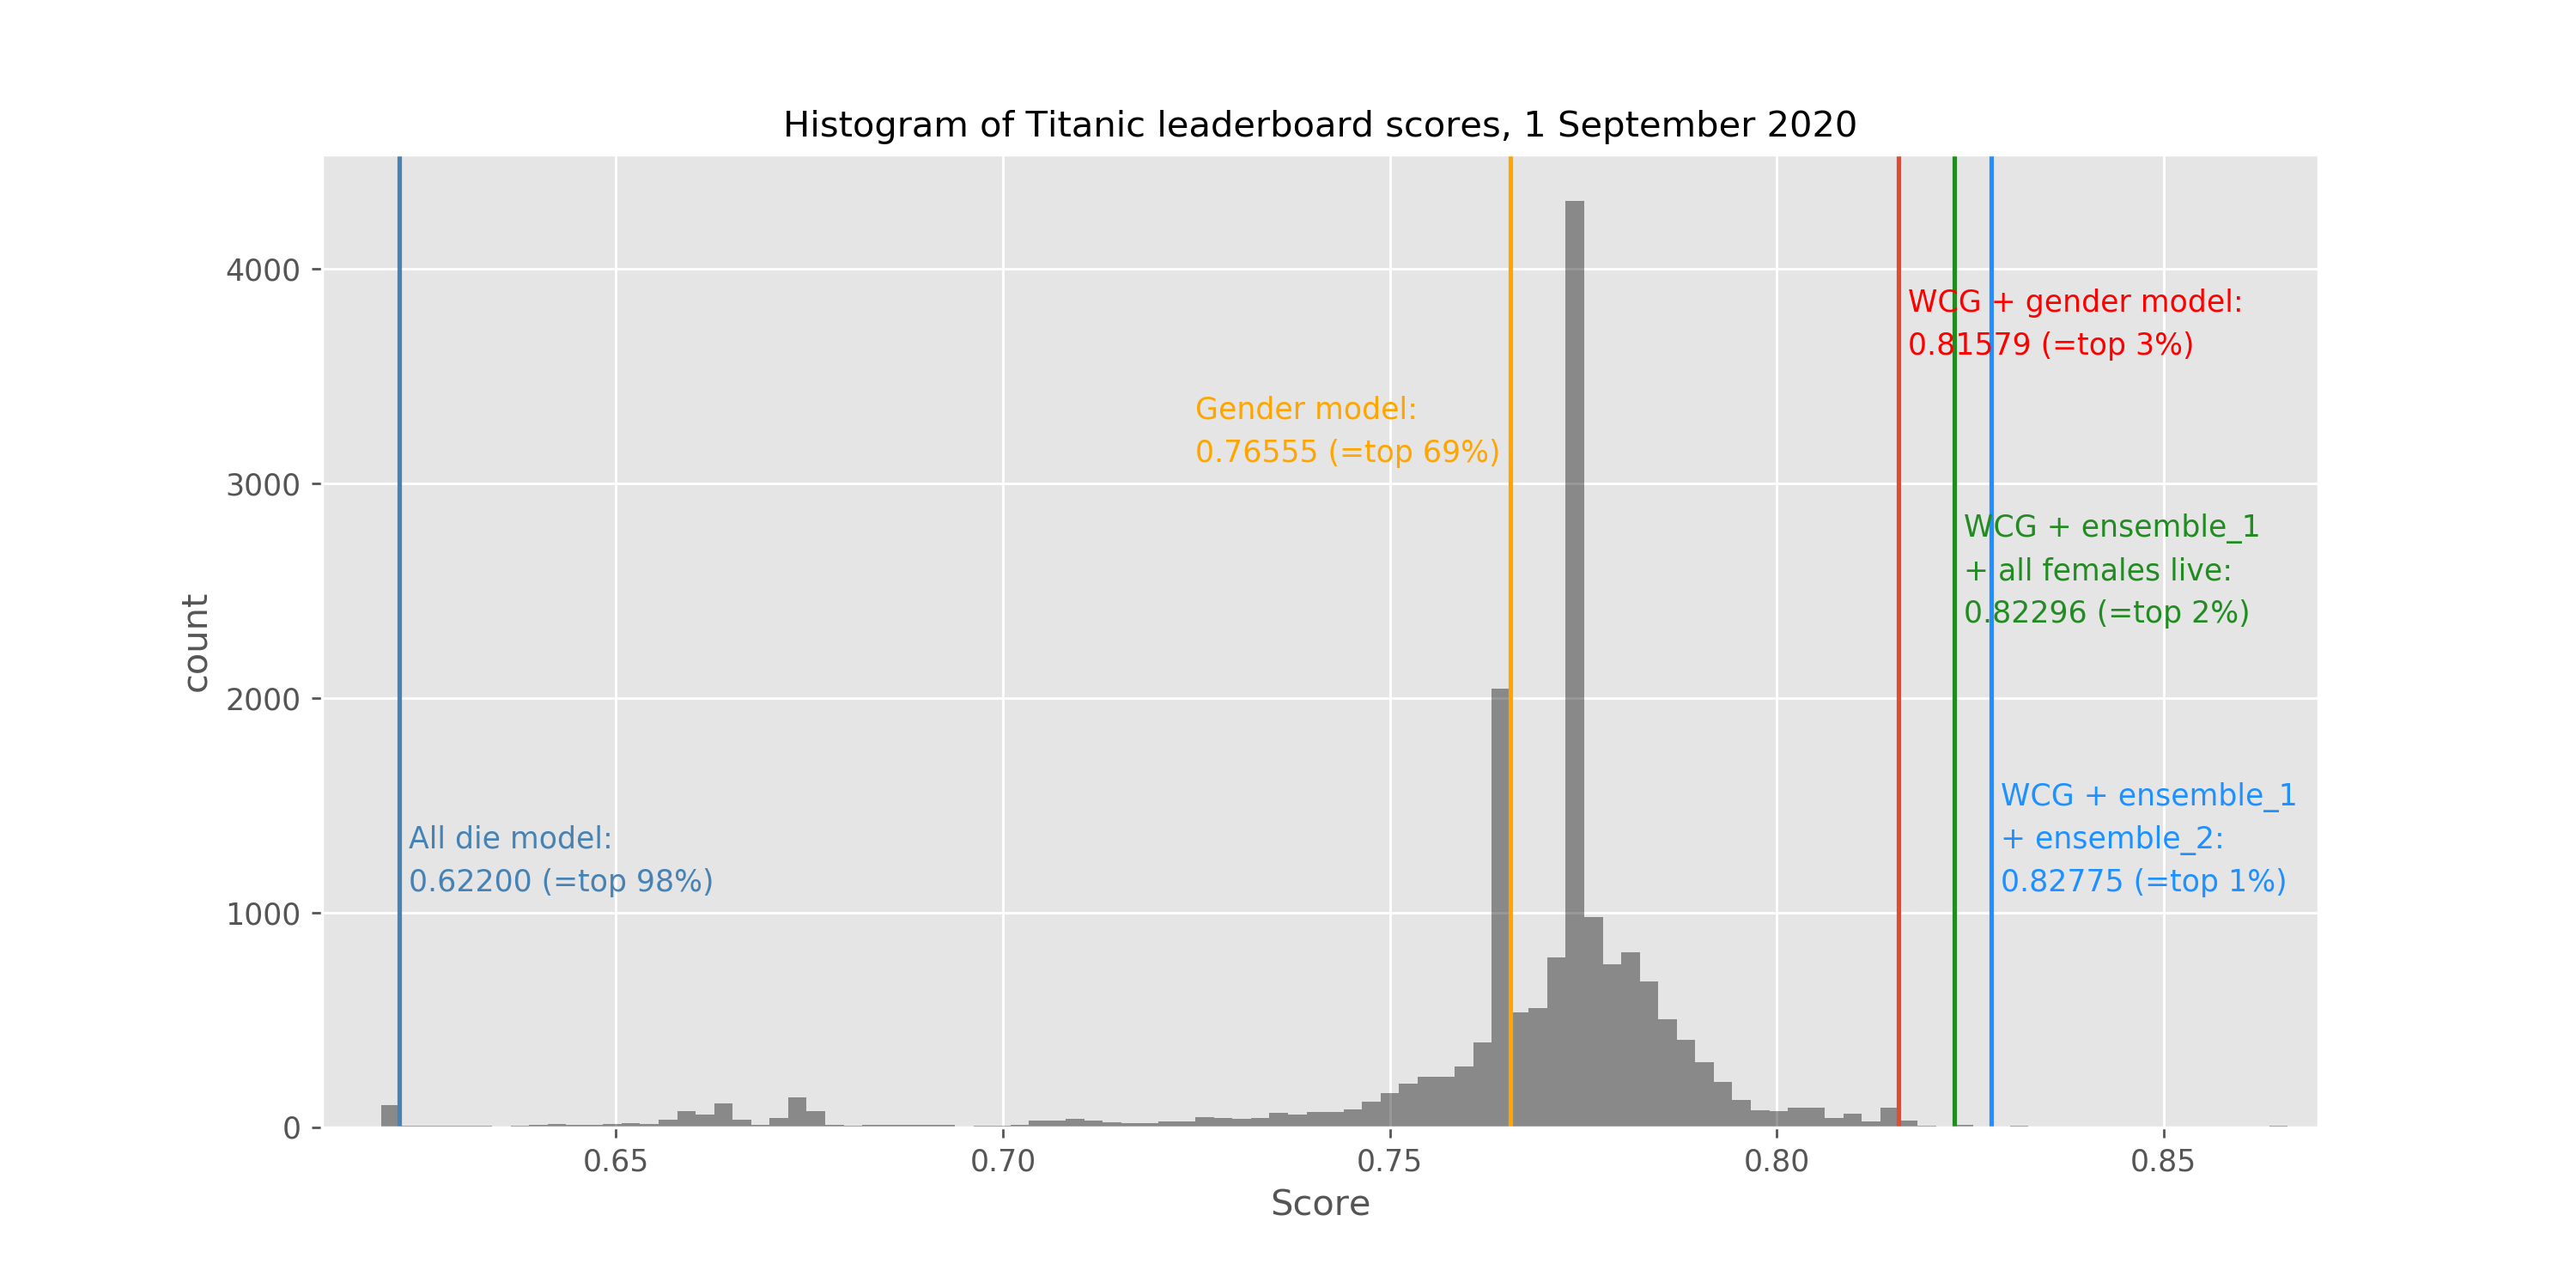
First, the passengers (train + test) were divided into four groups:
1. Adult males - 60% of the population (A)
1. Young boys (with Master title) - 5% of the population (B)
1. Females that have children, sisters, or mothers (brothers and husbands are optional) - 13% of the population (C)
1. Females that have brothers, or husbands (no children, no sisters, no mothers) or are traveling alone - 22% of the population (D)

Next, we built 3 classifiers:
1. **WCG** on top of the **gender model** to classify (B) + (C)
1. **Ensemble_1** of KNNs to classify (A)
1. **Ensemble_2** of KNNs to classify (D)

Finally we assembled the models. Here are the public scores:
1. **WCG + gender model** scores 81,6% which is 341 correct predictions
1. **WCG + ensemble_1 + all females live** scores 82,3% which is 344 correct predictions
1. **WCG + ensemble_1 + ensemble_2** scores 82,8% which is 346 correct predictions

See you soon in the next one and good luck passing 83%!  
Please let me know down in the comments your suggestions or if you find errors in the code!